<a href="https://colab.research.google.com/github/KGochae/Youtube/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 패키지 import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import platform
import warnings
import pickle
import re

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Dense, GRU, Dropout,LSTM, Bidirectional, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.preprocessing.text import Tokenizer

warnings.filterwarnings("ignore")

# 데이터 결합 및 일부 라벨 수정
* clean(긍정) = 1  중립,부정 = 0

In [ ]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
comment_df = pd.read_csv('/content/drive/MyDrive/comment_df.csv')
total_df = pd.read_csv('/content/drive/MyDrive/total_df.csv')
hate_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HateScore.csv')
dev = pd.read_csv('/content/drive/MyDrive/train.tsv',delimiter='\t')

In [ ]:
dev = dev.rename(columns={'comments':'reviews','hate':'sentiment'})
dev['sentiment'] = dev['sentiment'].apply(lambda x: 1 if x == 'none' else 0) # clean = 1 부정 = 0
dev = dev[['reviews','sentiment']]
dev['sentiment'].value_counts()

0    4410
1    3486
Name: sentiment, dtype: int64

In [ ]:
hate_df =  hate_df[hate_df['source'] == '온라인 댓글']
hate_df = hate_df.rename(columns={'comment': 'reviews','macrolabel':'sentiment'})
hate_df['sentiment'] = hate_df['sentiment'].apply(lambda x: 1 if x == 'Clean' else 0) # clean = 1 부정 = 0
hate_df = hate_df[['reviews','sentiment']]
hate_df['sentiment'].value_counts().plot(kind='bar')


In [ ]:
hate_df= hate_df[hate_df['sentiment'] == 0]
hate_df

In [ ]:
#  속성 단어사전 불러오기 , txt 파일을 list 형태로 불러오는 법
import codecs
with open('/content/drive/MyDrive/Colab Notebooks/multi_labeling_NLP/긍정.txt', encoding='utf-8') as pos:
  positive = pos.readlines()

positive = [pos.replace("\n", "")for pos in positive]


#positive list 안에 있는 단어가 포함되어있으면 1 아닌경우 0 으로 라벨
import re
labels = []

total = list(comment_df['comment'])

for token in tqdm(total):
  clean = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…\"\“》]', '', str(token))
  positive_flag = False
  label = 0
  for i in range(len(positive)):
    if positive[i] in clean:
      label = 1
      positive_flag = True
      break

  labels.append(label)

comment_df['sentiment'] = labels
comment_df = comment_df[['comment','sentiment']]
pos = comment_df[comment_df['sentiment'] == 1]

100%|██████████| 53298/53298 [00:00<00:00, 93925.72it/s]


In [ ]:
pos = pos.rename(columns={'comment': 'reviews'})

In [ ]:
total_df = pd.concat([pos,total_df], axis = 0 )
total_df = pd.concat([hate_df,total_df], axis=0)
total_df = pd.concat([total_df,dev], axis = 0)

In [ ]:
total_df['sentiment'].value_counts().plot(kind = 'bar')
print(total_df[total_df['sentiment'] == 0].count())
print(total_df[total_df['sentiment'] == 1].count())

In [ ]:
sample = total_df.sample(100)

# 자연어 전처리

In [ ]:
# !bash install_mecab-ko_on_colab_light_220429.sh

! git clone https://github.com/lovit/customized_konlpy.git
! pip install customized_konlpy

Cloning into 'customized_konlpy'...
remote: Enumerating objects: 618, done.
remote: Total 618 (delta 0), reused 0 (delta 0), pack-reused 618
Receiving objects: 100% (618/618), 950.06 KiB | 20.65 MiB/s, done.
Resolving deltas: 100% (345/345), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.5/881.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 58.2 MB/s eta 0:00:00


In [ ]:
total_df['reviews'] = total_df['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  #정규 표현식 수행
total_df['reviews'].replace('', np.nan, inplace=True)  #비어 있는 행은 null값으로 처리
total_df.dropna(how='any', inplace=True)  #null 값 제거
total_df.drop_duplicates(subset = ['reviews'], inplace=True) #중복된 행 제거

In [ ]:
# 리뷰 단어사전 추가
from ckonlpy.tag import Twitter
twi = Twitter()

words = [
          (['우왁굳','왁굳','영택'],'Noun'),
          # 이세돌
          (['챠니','챤이','비챤'],'Noun'), (['이세돌','이세계'],'Noun'),
          (['버거','징버거'],'Noun'), ('릴파', 'Noun'), (['르르땅','주르르'],'Noun'), (['아잉네','아이네'],'Noun'),(['세구','고세구','눈나구'],'Noun'),
          ('지구즈','Noun'),('언니즈','Noun'),('막내즈','Noun'),('헨타이','Noun'), ('튽훈','Noun'),('가성비','Noun'),

           (['레전드','레게노'],'Noun'), (['아웃트로','인트로'],'Noun'),(['브이알챗','브이알'],'Noun'),(['수듄','고로시','뇌절'],'Noun'),(['킹아','킹애','존맛탱'],'Adjective'),
          (['상현','하현'],'Noun'), (['고멤','고정멤버','아카데미'],'Noun'), (['고단씨','준구구','준99'],'Noun'),(['십덕','씹덕','오타쿠'],'Noun'),

          (['왁타버스','왁타'],'Noun'), (['루숙','해루석'],'Noun'),(['뢴트','뢴트게늄'],'Noun'),('비하인드','Noun'), (['춘식','곽춘식'],'Noun'),
          ('호드','Noun'), (['캘칼','캘리칼리'],'Noun'),(['왁파고','황파고'],'Noun'),(['혜지','독고혜지'],'Noun'), (['히키퀸','히키킹'],'Noun'), ('도파민','Noun'),
          ('닌닌','Noun'), ('시리안','Noun'), ('젠투','Noun'), ('공대진','Noun'), (['셈이','수셈이'],'Noun'), ('빅토리','Noun'),('발렌타인','Noun'),('아마최','Noun'),('아마데우스최','Noun'),
          ('세용','Noun'), (['진희','지니'],'Noun'), (['ㄱㅇㅇ','ㄹㄱㄴ','ㄺㄴ','ㅅㅌㅊ','ㅎㅌㅊ','ㅆㅅㅌㅊ','ㅆㅎㅌㅊ'],'KoreanParticle'),
          (['메갈','일베','재기'],'Noun')


         ]

for word in words:
    name, poomsa = word
    twi.add_dictionary(name, poomsa)

In [ ]:
text = '인조적인 아름다움에 눈코뜰새없다최근본영화중 최고'
print(twi.pos(text,norm=True)) # 띄어쓰기가 안된경우 확실히 거슬린다..

text= ' 도입부 레게노'
print(twi.pos(text,norm=True))


[('인', 'Noun'), ('조적', 'Noun'), ('인', 'Josa'), ('아름', 'Noun'), ('다', 'Josa'), ('움', 'Noun'), ('에', 'Josa'), ('눈코뜰새', 'Noun'), ('없다', 'Adjective'), ('최근', 'Noun'), ('본영', 'Noun'), ('화중', 'Noun'), ('최고', 'Noun')]
[('도입', 'Noun'), ('부', 'Noun'), ('레게노', 'Noun')]


In [ ]:
with tf.device('/device:GPU:0'):
  text_token = []
  for sentence in tqdm(total_df['reviews'].sample(100)):
      tmp = []
      tmp = twi.pos(sentence, norm=True)  #토큰화
      text_token.append(tmp)

100%|██████████| 100/100 [00:01<00:00, 58.42it/s]


In [ ]:
text_token

In [ ]:
stopwords = ['의', '가', '이', '은', '는', '과', '도', '를', '으로', '자', '에', '고', '세요', '니다', '입니다',
             '하다', '을', '이다', '다', '것', '로', '에서', '그', '인', '서', '네요', '음', '임','랑',
             '게', '요', '에게', '엔', '이고', '네', '거', '예요', '이에요', '어요', '어서', '여요', '하여']

In [ ]:
stopwords = ['의', '가', '이', '은', '는', '과', '도', '를', '으로', '자', '에', '세요', '니다', '입니다',
             '하다', '을', '이다', '다', '것', '로', '에서', '그', '서', '네요', '음', '임','랑',
             '게', '요', '에게', '엔', '이고', '거', '예요', '이에요', '어요', '여요', '하여', '하고']

with tf.device('/device:GPU:0'):
  text_token = []
  for sentence in tqdm(total_df['reviews']):
      tmp = []
      tmp = twi.morphs(sentence, norm=True)  #토큰화
      tmp = [word for word in tmp if not word in stopwords]  #불용어 제거
      text_token.append(tmp)

100%|██████████| 247931/247931 [10:39<00:00, 387.83it/s]


In [ ]:
text_token

[['아'], ['이'], ['네'], [], ['귀'], ['여'], ['워'], [], ['ㅋ'], ['ㅋ']]

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_token)


In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 107201
등장 빈도가 1번 이하인 희귀 단어의 수: 53085
단어 집합에서 희귀 단어의 비율: 49.519127620078166
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8461259177160274


In [ ]:
# 빈도수 2이하인 단어 제거하고 0 추가한 개수 = vocab_size
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 54117


In [ ]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(text_token)

X = tokenizer.texts_to_sequences(text_token)

print('리뷰의 최대 길이 :',max(len(l) for l in X))
print('리뷰의 최소 길이 :',min(len(l) for l in X))
print('리뷰의 평균 길이 :',sum(map(len, X))/len(X))

리뷰의 최대 길이 : 618
리뷰의 최소 길이 : 0
리뷰의 평균 길이 : 11.383796298163603


전체 샘플 중 길이가 44 이하인 샘플의 비율: 98.70246157196962


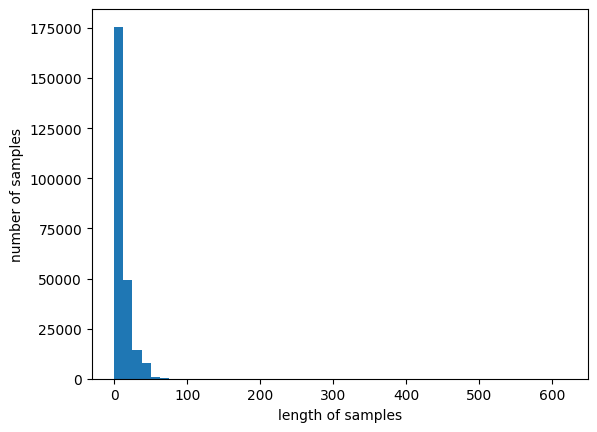

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 44
below_threshold_len(max_len, X)

plt.hist([len(review) for review in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, maxlen = max_len)
y = total_df['sentiment']


In [ ]:
# 워드클라우드 TEST
from wordcloud import WordCloud
import random
import warnings
warnings.filterwarnings("ignore")

FONT_PATH = '/content/drive/MyDrive/BMDOHYEON_ttf.ttf'

pal = ['#303C55', '#E47F2D', '#FBB243', '#F9CA18', '#4F596E','#747B86']

def color(word, font_size, position, orientation, random_state=None, **kwargs):
    i = random.randint(0,5)
    return pal[i]

wc = WordCloud(font_path=FONT_PATH, background_color='white',
              width=1600, height=800, color_func=color).generate_from_frequencies(tokenizer.word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wc)
plt.tight_layout(pad=20)
plt.axis('off')

# 모델링
## LSTM


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train = np.array(X_train)
X_test = np.array(X_test)


# y_train, y_test의 클래스별 개수 계산
train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)

print("Train Class Counts:")
print(train_class_counts)

print("\nTest Class Counts:")
print(test_class_counts)


In [ ]:
from tensorflow.keras.layers import LSTM, Dropout

with tf.device('/device:GPU:0'):
  embedding_dim = 100
  hidden_units = 128  # 노드 수를 줄임

  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(LSTM(hidden_units))
  model.add(Dropout(0.5))  # 드롭아웃 추가
  model.add(Dense(1, activation='sigmoid'))  # 클래스 개수에 맞게 수정

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=64, validation_split=0.2)

model.save('/content/lstm_08.h5')


Epoch 1/10
2325/2325 [==============================] - ETA: 0s - loss: 0.4144 - accuracy: 0.8058

2325/2325 [==============================] - 80s 30ms/step - loss: 0.4144 - accuracy: 0.8058 - val_loss: 0.3686 - val_accuracy: 0.8328
Epoch 2/10
2325/2325 [==============================] - ETA: 0s - loss: 0.3397 - accuracy: 0.8525

2325/2325 [==============================] - 23s 10ms/step - loss: 0.3397 - accuracy: 0.8525 - val_loss: 0.3587 - val_accuracy: 0.8421
Epoch 3/10
2325/2325 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.8714

2325/2325 [==============================] - 19s 8ms/step - loss: 0.3061 - accuracy: 0.8714 - val_loss: 0.3447 - val_accuracy: 0.8489
Epoch 4/10
2325/2325 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.8888

2325/2325 [==============================] - 18s 8ms/step - loss: 0.2749 - accuracy: 0.8888 - val_loss: 0.3461 - val_accuracy: 0.8498
Epoch 5/10
2325/2325 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.9034

2325/2325 [==============================] - 20s 9ms/step - loss: 0.2469 - accuracy: 0.9034 - val_loss: 0.3615 - val_accuracy: 0.8510
Epoch 6/10
2317/2325 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9159

2325/2325 [==============================] - 18s 8ms/step - loss: 0.2213 - accuracy: 0.9158 - val_loss: 0.3563 - val_accuracy: 0.8495
Epoch 7/10
2325/2325 [==============================] - ETA: 0s - loss: 0.1993 - accuracy: 0.9257

2325/2325 [==============================] - 20s 8ms/step - loss: 0.1993 - accuracy: 0.9257 - val_loss: 0.3952 - val_accuracy: 0.8464
Epoch 7: early stopping


In [ ]:
loaded_model = load_model('/content/lstm_08.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1937/1937 [==============================] - 9s 4ms/step - loss: 0.3911 - accuracy: 0.8461

 테스트 정확도: 0.8461


In [ ]:
import pickle

In [ ]:
# 토크나이저 저장
file_path = '/content/drive/MyDrive/tokenizer3.pickle'

with open(file_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
tokenizer_pickle_path = "/content/drive/MyDrive/tokenizer.pickle"
with open(tokenizer_pickle_path, "rb") as f:
    tokenizer = pickle.load(f)

In [ ]:
import re


def test(comment):
  comment = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', comment)
  tmp = twi.morphs(comment,stem=True,norm=True)  #토큰화
  tmp = [word for word in tmp if not word in stopwords]  #불용어 제거
  encoded = tokenizer.texts_to_sequences([tmp])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(loaded_model.predict(pad_new))

  print(tmp)
  print(encoded)
  print(pad_new)

  return score


test('올랜님 진짜 영상편집에 공들이신게 보이네 멤버별 각각 소리 키우고 줄이고 노래 다시 ...	')


1/1 [==============================] - 0s 69ms/step
['올', '랜', '님', '진짜', '영상편집', '공', '들', '이신', '보이', '네', '멤버', '별', '각각', '소리', '키우다', '줄', '노래', '다시']
[[493, 26207, 79, 5, 29400, 1172, 3, 3851, 361, 33, 1756, 164, 4120, 390, 53802, 182, 80, 76]]
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0   493 26207    79     5 29400  1172     3  3851   361    33
   1756   164  4120   390 53802   182    80    76]]


0.9935697317123413

In [ ]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
total_df['sentiment'].value_counts().plot(kind='bar')

In [ ]:
youtube_df = pd.read_csv('/content/측정비교.csv')
youtube_df = youtube_df[['comment','score','sentiment']]

In [ ]:
youtube_df.dropna(how='any', inplace=True)  #null 값 제거
youtube_df.drop_duplicates(subset = ['comment'], inplace=True) #중복된 행 제거

In [ ]:
df = youtube_df.sample(10)

In [ ]:
youtube_df['lstm_score'] = youtube_df['comment'].apply(test)

In [ ]:
youtube_df['Bi_attention_score'] = youtube_df['comment'].apply(attention_bilstm)

In [ ]:
youtube_df.to_csv('score_비교.csv', index=False, encoding='utf-8-sig')

# BiLSTM

In [ ]:
# bilstm 양방향
with tf.device('/device:GPU:0'):
  embedding_dim = 100
  hidden_units = 64

  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
  model.add(Dropout(0.6))  # 드롭아웃 추가
  model.add(Dense(1, activation='sigmoid'))

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=128, validation_split=0.2)

model.save('/content/best_model_0726_2.h5')


In [ ]:
loaded_model = load_model('best_model_0726_2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1789/1789 [==============================] - 10s 5ms/step - loss: 0.3650 - acc: 0.8497

 테스트 정확도: 0.8497


In [ ]:
import re

max_len = 42

def test(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  tmp = twi.morphs(new_sentence)  #토큰화
  tmp = [word for word in tmp if not word in stopwords]  #불용어 제거
  encoded = tokenizer.texts_to_sequences([tmp])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(model.predict(pad_new))

  print(tmp)
  print(encoded)
  print(pad_new)
  print(score)

test('와 화음 진짜 미쳤다. 진짜 황홀하네요')

1/1 [==============================] - 13s 13s/step
['와', '화음', '진짜', '미쳤다', '진짜', '황홀', '하네요']
[[49, 5293, 9, 9, 4589]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0   49 5293    9    9 4589]]
0.999693751335144


### 맞춤법 전처리
* 맞춤법에 따라 점수가 크게 차이난다.. '황올하내' 라는 문장은 사실 황홀하다 라는 표현 일텐데 부정적으로 판단하게된다..
*  아래의 한스펠로 맞춤법이나 오타를 어느정도 고칠 수 있다, 되는것도 있고 안되는것도 있는것 같다.

* 한스펠을 이용한 경우, 위의 경우는 여전히 '황올하내' 그대로 내뱉는다. 그래도.. 안하는것보다 나으려나? 그래도 띄어쓰기는 어느정도 잘 잡는것 같다.

> 18문장을 전부 처리하기에는 너무 오래걸린다..


In [ ]:
# 맞춤법 추가
!pip install git+https://github.com/ssut/py-hanspell.git


  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-v2ntf8st
  Running command git clone --filter=blob:none --quiet https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-v2ntf8st
  Resolved https://github.com/ssut/py-hanspell.git to commit fdc6ca50c19f1c85971437a072d89d4e5ce024b8
  Preparing metadata (setup.py) ... done
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4810 sha256=df53ef916f2d68a7cd7eb949f0b1c2aac967ceae1eaf39c981d75e19093e1115
  Stored in directory: /tmp/pip-ephem-wheel-cache-jyqclr0r/wheels/2e/43/cc/753c9e1d91affb9ea40e186cea5654fb9231deb454da6724e5
Successfully built py-hanspell


In [ ]:
from hanspell import spell_checker

sent = "귀차나"
spelled_sent = spell_checker.check(sent)

hanspell_sent = spelled_sent.checked
print(hanspell_sent)

귀찮아


# ATTENTION + bilstm

In [ ]:
import tensorflow as tf
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):

        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
embedding_dim = 128
hidden_units = 32

In [ ]:
sequence_input = Input(shape=(max_len,), dtype="int32")
embedded_sequences = Embedding(vocab_size, embedding_dim)(sequence_input)

In [ ]:
lstm = Bidirectional(LSTM(hidden_units, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(hidden_units, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
import tensorflow.keras as keras

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

# Removal of the globalMaxPool1D could be trouble
# globmax = GlobalMaxPool1D()(context_vector)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.4)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
print(model.summary())

# model visualize

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90) # 시각화

In [ ]:

with tf.device('/device:GPU:0'):
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
  BATCH_SIZE = 128
  EPOCHS = 15
  history = model.fit(X_train,y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks= es,
                      validation_split=0.2)

model.save('/content/bi_attention.h5')


Epoch 1/15
1074/1074 [==============================] - 101s 73ms/step - loss: 0.4035 - tp: 79766.0000 - fp: 16576.0000 - tn: 60788.0000 - fn: 14583.0000 - accuracy: 0.8185 - precision: 0.8279 - recall: 0.8454 - auc: 0.8875 - val_loss: 0.3451 - val_tp: 16366.0000 - val_fp: 2766.0000 - val_tn: 12716.0000 - val_fn: 2495.0000 - val_accuracy: 0.8468 - val_precision: 0.8554 - val_recall: 0.8677 - val_auc: 0.9257
Epoch 2/15
1074/1074 [==============================] - 31s 29ms/step - loss: 0.3017 - tp: 66427.0000 - fp: 8517.0000 - tn: 53365.0000 - fn: 9061.0000 - accuracy: 0.8720 - precision: 0.8864 - recall: 0.8800 - auc: 0.9444 - val_loss: 0.3502 - val_tp: 16129.0000 - val_fp: 2456.0000 - val_tn: 13026.0000 - val_fn: 2732.0000 - val_accuracy: 0.8489 - val_precision: 0.8679 - val_recall: 0.8552 - val_auc: 0.9271
Epoch 3/15
1074/1074 [==============================] - 28s 26ms/step - loss: 0.2492 - tp: 67950.0000 - fp: 6722.0000 - tn: 55160.0000 - fn: 7538.0000 - accuracy: 0.8962 - precision

In [ ]:
loaded_model = tf.keras.models.load_model('/content/bi_attention_2.h5', custom_objects={'BahdanauAttention': BahdanauAttention})


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))


1803/1803 [==============================] - 89s 49ms/step - loss: 0.3606 - accuracy: 0.8506

 테스트 정확도: 0.8506


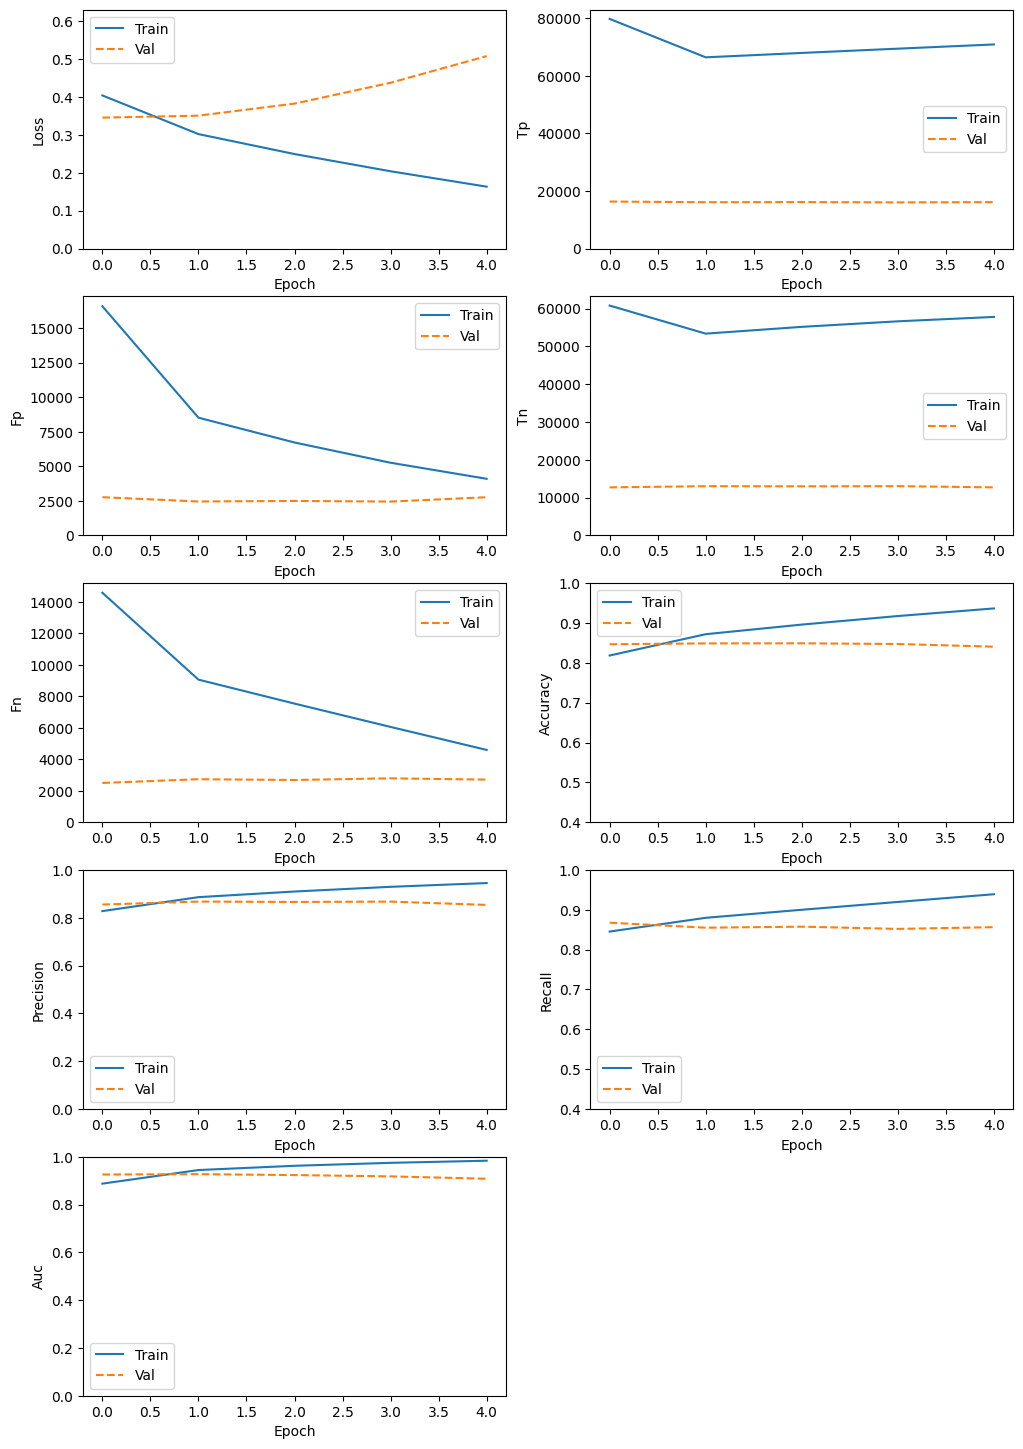

In [ ]:
import matplotlib as mpl


colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams["figure.figsize"] = (12, 18)

def plot_metrics(history):
    metrics = [
        "loss",
        "tp", "fp", "tn", "fn",
        "accuracy",
        "precision", "recall",
        "auc",
    ]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(5, 2, n + 1)
        plt.plot(
            history.epoch,
            history.history[metric],
            color=colors[0],
            label="Train",
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1] * 1.2])
        elif metric == "accuracy":
            plt.ylim([0.4, 1])
        elif metric == "fn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "fp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "precision":
            plt.ylim([0, 1])
        elif metric == "recall":
            plt.ylim([0.4, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

plot_metrics(history)

In [ ]:
max_len = 45

In [ ]:

def test_attention_model(loaded_model, tokenizer, new_sentence, max_len):
    # 토큰화와 불용어 제거 없이 원본 문장 유지
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', new_sentence)
    tmp = twi.morphs(new_sentence)  # 토큰화
    tmp = [word for word in tmp if not word in stopwords]  # 불용어 제거
    encoded = tokenizer.texts_to_sequences([tmp])
    pad_new = pad_sequences(encoded, maxlen=max_len)
    attention_weights = loaded_model.predict(pad_new)[0]

    print(tmp)
    print(attention_weights)

new_sentence = '시작부터 귀엽네 ㅋㅋㅋ'
test_attention_model(loaded_model, tokenizer, new_sentence, max_len)


1/1 [==============================] - 0s 24ms/step
['시작', '부터', '귀엽네', 'ㅋㅋㅋ']
[0.76274025]


In [ ]:
def test(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  tmp = twi.morphs(new_sentence)  #토큰화
  tmp = [word for word in tmp if not word in stopwords]  #불용어 제거
  encoded = tokenizer.texts_to_sequences([tmp])
  pad_new = pad_sequences(encoded, maxlen = 45)
  score = float(loaded_model.predict(pad_new))

  print(tmp)
  # # print(new_sentence)
  print(encoded)
  print(pad_new)
  print(score)

test('와 화음 진짜 미쳤다 진짜 황홀하내')


1/1 [==============================] - 0s 63ms/step
['와', '화음', '진짜', '미쳤다', '진짜', '황홀', '하내']
[[48, 5199, 9, 9, 4516, 5297]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0   48 5199    9
     9 4516 5297]]
0.9130785465240479


# attention(BahdanauAttention) + Bilstm

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


In [ ]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

In [ ]:
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)
# 두번째 층을 설계합니다. 상태를 리턴받아야 하므로 return_state를 True로 해주어야 합니다.

(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True), name="bi_lstm_2")(lstm)
# 각 상태의 크기(shape)를 출력해보겠습니다.

print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)


(None, 42, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [ ]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태
# 어텐션 메커니즘에서는 은닉 상태를 사용합니다. 이를 입력으로 컨텍스트 벡터(context vector)를 얻습니다.

attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)
# 컨텍스트 벡터를 밀집층(dense layer)에 통과시키고, 이진 분류이므로 최종 출력층에 1개의 뉴런을 배치하고, 활성화 함수로 시그모이드 함수를 사용합니다.

dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

# -----------------------------------------------------------------------------------------

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


In [ ]:
with tf.device('/device:GPU:0'):
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
  history = model.fit(X_train, y_train, epochs = 4, batch_size = 64, callbacks = es, validation_data=(X_test, y_test), verbose=1)

model.save('/content/bi_attention_2.h5')

Epoch 1/4
2704/2704 [==============================] - 1355s 488ms/step - loss: 0.4030 - accuracy: 0.8224 - val_loss: 0.3483 - val_accuracy: 0.8427
Epoch 2/4
2704/2704 [==============================] - 1280s 473ms/step - loss: 0.3236 - accuracy: 0.8658 - val_loss: 0.3387 - val_accuracy: 0.8510
Epoch 3/4
2704/2704 [==============================] - 1263s 467ms/step - loss: 0.2871 - accuracy: 0.8837 - val_loss: 0.3462 - val_accuracy: 0.8520
Epoch 4/4
2704/2704 [==============================] - 1262s 467ms/step - loss: 0.2553 - accuracy: 0.8971 - val_loss: 0.3606 - val_accuracy: 0.8506


In [ ]:
import re

max_len = 42

def test(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  tmp = twi.morphs(new_sentence,stem=True,norm=True)  #토큰화
  tmp = [word for word in tmp if not word in stopwords]  #불용어 제거
  encoded = tokenizer.texts_to_sequences([tmp])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(model.predict(pad_new))

  print(tmp)
  print(encoded)
  print(pad_new)
  print(score)

test('이딴게 재밌냐?')

1/1 [==============================] - 0s 94ms/step
['이딴', '재밌다']
[[527, 18]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0 527  18]]
0.24862578511238098


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query):
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedded_sequences = tf.keras.layers.Embedding(vocab_size, 128, input_length=max_len, mask_zero=True)(sequence_input)

lstm = tf.keras.layers.LSTM(64, dropout=0.5, return_sequences=True)(embedded_sequences)

attention = BahdanauAttention(64)  # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, lstm)  # Attention 적용

dense1 = tf.keras.layers.Dense(20, activation="relu")(context_vector)
dropout = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)
model = tf.keras.Model(inputs=sequence_input, outputs=output)
